----------
Import
----------

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F


from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.nn import CrossEntropyLoss

import cv2
import numpy as np
import matplotlib.pyplot as plt

-----------
Download data
-----------

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


----------
Data split and use DataLoader
----------

In [4]:
validation_ratio=0.1
random_seed= 17

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(validation_ratio * num_train))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          sampler=valid_sampler, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [5]:
print("train set : ",len(train_sampler))
print("validation set : ",len(valid_sampler))
print("test set : ",len(test_dataset))

train set :  45000
validation set :  5000
test set :  10000


------------
Make module 
------------

each no batch normalization -> Net_nobn, </br>
Using batch normalization -> Net_bn

In [17]:
class Net_nobn(nn.Module):
    def __init__(self):
        super(Net_nobn, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net_nobn = Net_nobn().to(device)


class Net_bn(nn.Module):
    def __init__(self):
        super(Net_bn, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net_bn = Net_bn().to(device)

cuda:0
cuda:0


-----------------
No batch normalization
-----------------


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_nobn.parameters(), lr=0.001, momentum=0.9)

In [37]:
nb_epoch = 10

for epoch in range(nb_epoch): 

    net_nobn.train()

    running_loss = 0.0
    loss_values = []
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net_nobn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        if i % 5000 == 4999:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5000))
            running_loss = 0.0

    loss_values.append(running_loss / len(train_dataset))

    net_nobn.eval()

    correct = 0 
    total = 0

    with torch.no_grad():
        for data in validloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_nobn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    acc = correct / total 

print('Finished Training')

RuntimeError: ignored

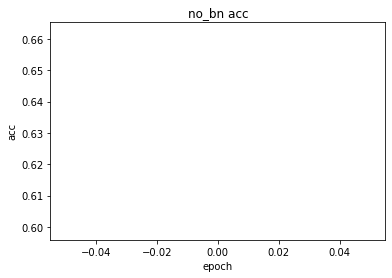

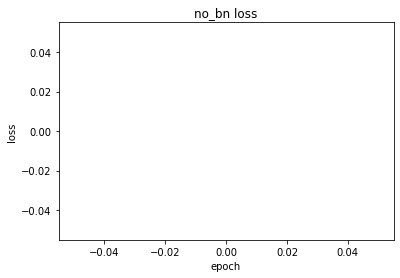

In [35]:
plt.plot(acc, label = 'nobn_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('no_bn acc')
plt.show()


plt.plot(loss_values, label = 'nobn_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('no_bn loss')
plt.show()

In [20]:
PATH1 = './cifar_net_nobn.pt'
torch.save(net_nobn.state_dict(), PATH1)

In [21]:
net_nobn = Net_nobn()
net_nobn.load_state_dict(torch.load(PATH1))
net_nobn.eval()

Net_nobn(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_nobn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of test dataset : %d %%' % (
    100 * correct / total))

RuntimeError: ignored

------------------
Using batch normalization
------------------

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_bn.parameters(), lr=0.001, momentum=0.9)

In [28]:
nb_epoch = 10

for epoch in range(nb_epoch): 

    net_bn.train()

    running_loss = 0.0
    loss_values = []
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net_bn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        if i % 5000 == 4999:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5000))
            running_loss = 0.0

    loss_values.append(running_loss / len(train_dataset))

    net_bn.eval()

    correct = 0 
    total = 0

    with torch.no_grad():
        for data in validloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_bn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    acc = correct / total 

print('Finished Training')

[1,  5000] loss: 5.423
[1, 10000] loss: 5.337
[2,  5000] loss: 5.290
[2, 10000] loss: 5.237
[3,  5000] loss: 5.171
[3, 10000] loss: 5.168
[4,  5000] loss: 5.049
[4, 10000] loss: 5.114
[5,  5000] loss: 5.031
[5, 10000] loss: 5.018
[6,  5000] loss: 4.905
[6, 10000] loss: 4.970
[7,  5000] loss: 4.871
[7, 10000] loss: 4.906
[8,  5000] loss: 4.790
[8, 10000] loss: 4.823
[9,  5000] loss: 4.714
[9, 10000] loss: 4.781
[10,  5000] loss: 4.650
[10, 10000] loss: 4.721
Finished Training


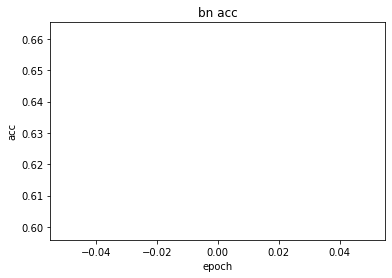

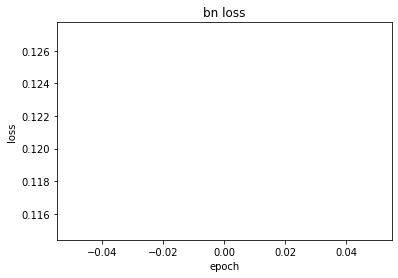

In [29]:
plt.plot(acc, label = 'bn_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('bn acc')
plt.show()


plt.plot(loss_values, label = 'bn_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('bn loss')
plt.show()

In [30]:
PATH2 = './cifar_net_bn.pt'
torch.save(net_bn.state_dict(), PATH2)

In [31]:
net_bn = Net_bn()
net_bn.load_state_dict(torch.load(PATH2))
net_bn.eval()

Net_bn(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2_bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_bn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of test dataset : %d %%' % (
    100 * correct / total))

RuntimeError: ignored

-----------------
과제 한계점.
-----------------

-  그래프가 올바르게 출력이 안됨. 
-  그래프 구현을 위해 훈련 코드에 loss, acc값 저장하는 리스트 추가후 다시 훈련 -> 시간 부족으로 10epoch만 우선 돌림.

- 배운점. batch -normalization 을 모델에 추가하는 방법, plot을 이용해 legend및 여러 기능을 사용하는 방법